# HW4 - Applied ML

There are four aspects:
* First, we process the data and explore the dataset (0).
* Then, we classify labels. (1).
* We plot learning curves (Bonus)
* Finally, we do clustering (2).

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import sklearn.model_selection
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler
from sklearn.model_selection import ShuffleSplit
from IPython import display
import sklearn
%matplotlib inline

## 0. Data Pre-Processing and Visualization
Understanding the dataset, cleaning the variables. This is important because later we will need clean data for supervised and unsupervised learning.

Using ideas from http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb, we will clean the dataset. Then, we will aggregate information. Finally, we will clean up the features.

### Pre-Processing Tasks and Outline

* Dataset cleaning
    - exclude interactions by  ref who feature in fewer than 22 dyads
    - drop NAs with no race values, averaging race values

* Aggregate to player data
    - combine games, referee and bias information using variable statistics

* Cleaning features
    - take out unnecessary features — player ID, photo ID
    - convert categorical variables into numerical values


In [2]:
df = pd.read_csv('Data/CrowdstormingDataJuly1st.csv')

In [3]:
orig_num_dyads = df.shape[0]
print('Number of dyads:', orig_num_dyads)

Number of dyads: 146028


## Dataset Cleaning

### Exclude Interactions

In [4]:
#This line defines a new dataframe based on our >21 games filter
all_refs = df.refNum.value_counts()
good_refs = all_refs[all_refs>21]

df=df[df['refNum'].isin(good_refs.index.values)]

In [5]:
print('percentage of dyads left:', 100 * df.shape[0] / orig_num_dyads)

percentage of dyads left: 91.4215082039061


### Getting Race Values

Get the "race value" by taking the mean of the two rater values. Then drop the ones that don't have a rating. 

In [6]:
# We verify that it is never the case that only one of the rater field is NaN
df[((df.rater1.notnull()) & (df.rater2.isnull())) | ((df.rater1.isnull()) & (df.rater2.notnull()))]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp


In [7]:
df['race_val'] = (df['rater1'] + df['rater2'])/2
df.dropna(subset=['race_val'],inplace=True)

In [8]:
print('percentage of dyads left:', 100 * df.shape[0] / orig_num_dyads)

percentage of dyads left: 77.9727175610157


In [9]:
df_new=df.copy()

# Get rid of irrelevant columns
df_new.drop(['rater1','rater2','player','photoID','Alpha_3','birthday', 'refNum'],axis=1, inplace=True)

# Check which columns have null values and for how many pla
df_new.isnull().sum()

playerShort         0
club                0
leagueCountry       0
height             23
weight            625
position         7719
games               0
victories           0
ties                0
defeats             0
goals               0
yellowCards         0
yellowReds          0
redCards            0
refCountry          0
meanIAT           110
nIAT              110
seIAT             110
meanExp           110
nExp              110
seExp             110
race_val            0
dtype: int64

**Taking care of null values**

Before aggregating the data, we need to take care of the null values
* We replace the height and weight by the mean. We justify this by lookng at the distribution of heoght and weight.
* We replace the null values in position by a string. There are too many nulls in position to get rid of. If we do not get a good classification, we can get rid of the nulls later and try to see if that makes a difference.
* We verify that all the IAT and Exp values are null for the same set of countries, and remove them as they are quite small in number.

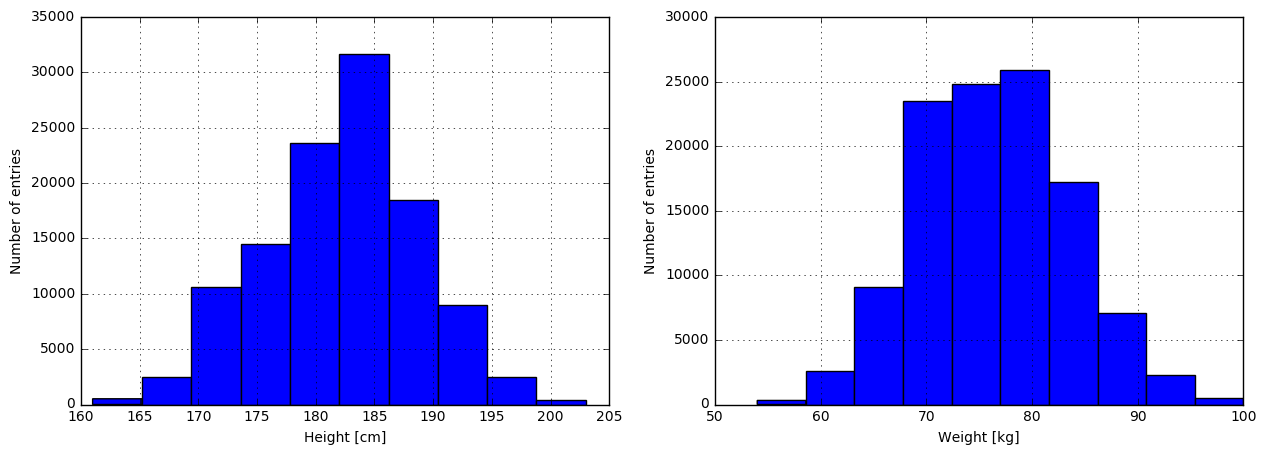

In [10]:
# Distribution for height and weight
fig, axs = plt.subplots(1,2,  figsize=(15, 5))

df_new['height'].hist(ax=axs[0])
axs[0].set_ylabel('Number of entries')
axs[0].set_xlabel('Height [cm]')
df_new['weight'].hist(ax=axs[1])
axs[1].set_ylabel('Number of entries')
axs[1].set_xlabel('Weight [kg]')

In [11]:
# Replacing the height and weight by the mean

mean_weight = df_new['weight'][df_new.weight.notnull()].mean()
mean_height = df_new['height'][df_new.height.notnull()].mean()
print(mean_weight, mean_height)
df_new['weight'].fillna(mean_weight, inplace=True)
df_new['height'].fillna(mean_height, inplace=True)

76.31274230154455 182.0956877695693


In [12]:
# Too many NAs for position so not dropping them for now
df_new['position'].fillna('NA', inplace=True)

In [13]:
# All NAs for same countries for all IAT and Exp columns 
print(df_new[df_new.meanIAT.isnull()]['refCountry'].unique(),
df_new[df_new.nIAT.isnull()]['refCountry'].unique(),
df_new[df_new.seIAT.isnull()]['refCountry'].unique(),
df_new[df_new.meanExp.isnull()]['refCountry'].unique(),
df_new[df_new.nExp.isnull()]['refCountry'].unique(),
df_new[df_new.seExp.isnull()]['refCountry'].unique())


[ 16 138] [ 16 138] [ 16 138] [ 16 138] [ 16 138] [ 16 138]


In [14]:
# Not many NAs so we can drop them
df_new[df_new.meanIAT.isnull()].shape
df_new.dropna(inplace=True)

**Covert categorical data to numerical values**

We need to convert the categorical data to numerical values to enable us to train the random forest classifier. We siply give each categorical value a different numerical value for the categorical columns.

In [15]:
# The categorical columns
cols = ['club', 'leagueCountry', 'position']

# Converts the column to categorical numerical values 
df_cat = df_new[cols].apply(LabelEncoder().fit_transform)

In [16]:
# Remove the text columns and add the new numerical colums for the categorical data
df_new.drop(cols, axis=1, inplace=True)
df_categorized = pd.concat([df_new, df_cat], axis=1)

In [17]:
df_categorized.reset_index(drop=True, inplace = True)
df_categorized.head()

,playerShort,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,...,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,race_val,club,leagueCountry,position
0,aaron-hughes,182.0,71.0,1,0,0,1,0,0,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,34,0,1
1,aleksandar-kolarov,187.0,80.0,1,1,0,0,0,0,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,48,0,6
2,alexander-tettey,180.0,68.0,1,0,0,1,0,0,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000,54,0,4
3,anders-lindegaard,193.0,80.0,1,0,1,0,0,0,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.250,49,0,5
4,andreas-beck,180.0,70.0,1,1,0,0,0,0,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000,2,2,10


**Next, we aggregate the data by player as required for the task**

In [18]:
# each set of columns will be aggregated differently

# basis on which to group
player_cols = ['playerShort'] 

# We will sum these columns
game_cols = ['games','victories','ties','defeats','goals','yellowCards','yellowReds','redCards']

# We take the mode for these columns
ref_cols = ['refCountry' ]

# We take the mean for these columns
mean_cols = ['meanIAT','meanExp', 'race_val', 'height', 'weight', 'club', 'leagueCountry', 'position'] 

# We will sum these columns
bias_n_cols = ['nIAT','nExp'] 

#special function
bias_se_cols = ['seIAT', 'seExp'] 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0feac31160>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0feab6c5f8>]], dtype=object)

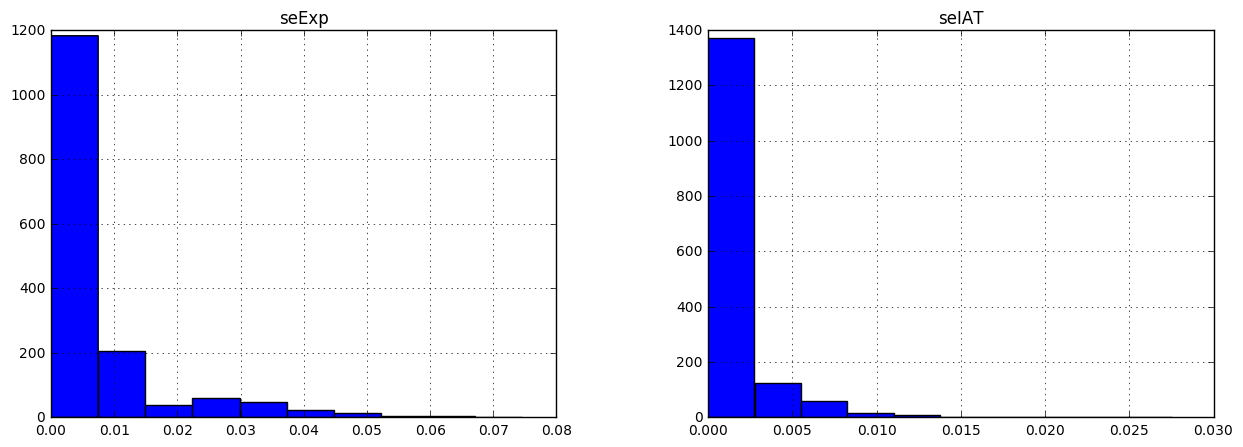

In [19]:
df_categorized.groupby(player_cols)[bias_se_cols].std().hist(figsize=(15, 5))

In [20]:
df_aggregated = df_categorized.groupby(player_cols)[game_cols].sum().reset_index()
df_aggregated = df_aggregated.merge(df_categorized.groupby(player_cols)[ref_cols].agg(lambda x: x.value_counts().index[0]).reset_index()) # refs
df_aggregated = df_aggregated.merge(df_categorized.groupby(player_cols)[mean_cols].mean().reset_index()) # bias mean
df_aggregated = df_aggregated.merge(df_categorized.groupby(player_cols)[bias_n_cols].sum().reset_index()) #bias n
df_aggregated = df_aggregated.merge(df_categorized.groupby(player_cols)[bias_se_cols].std().reset_index()) #bias std

In [21]:
df_aggregated.shape

(1584, 22)

In [22]:
df_aggregated.head()

,playerShort,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,refCountry,...,race_val,height,weight,club,leagueCountry,position,nIAT,nExp,seIAT,seExp
0,aaron-hughes,641,243,176,222,9,19,0,0,44,...,0.125,182.0,71.0,34,0,1,3133820.0,3281187.0,0.000707,0.003308
1,aaron-hunt,329,140,70,119,59,39,0,1,8,...,0.125,183.0,73.0,90,2,0,2553329.0,2627685.0,0.000508,0.002356
2,aaron-lennon,412,200,97,115,31,11,0,0,44,...,0.250,165.0,63.0,82,0,11,2144721.0,2246113.0,0.001220,0.008723
3,aaron-ramsey,254,145,42,67,39,31,0,1,44,...,0.000,178.0,76.0,6,0,3,3975720.0,4124639.0,0.001406,0.009682
4,abdelhamid-el-kaoutari,124,41,40,43,1,8,4,2,7,...,0.250,180.0,73.0,51,1,1,104797.0,109292.0,0.006216,0.023134


In [23]:
#Standardization
df_ml=df_aggregated.copy()

In [24]:
# Some null values come up for se columns but since they are quite less we just remove them
df_ml.isnull().sum()

playerShort      0
games            0
victories        0
ties             0
defeats          0
goals            0
yellowCards      0
yellowReds       0
redCards         0
refCountry       0
meanIAT          0
meanExp          0
race_val         0
height           0
weight           0
club             0
leagueCountry    0
position         0
nIAT             0
nExp             0
seIAT            5
seExp            5
dtype: int64

In [25]:
#We can see that there are 5 rows with NaN values in the seIAT and seEXP columns, those rows represent only the 0.25% 
#of the total of the players
df_ml.dropna(inplace=1)

In [26]:
#For the unsupervised learning, we assign the dependent variable (y) to the 'race_val' column, because we want
#to predict the color of the player.
y=np.asarray(df_ml['race_val'], dtype="|S6")

#Discretizing the values of y: 1 is for black players and 0 is for white players
for i in range(len(y)):
    if y[i]>b'0.5':
        y[i]=1
    else:
        y[i]=0
        
#For the features(x), we let all the columns except for 'playerShort' (only was used for the aggregation by player) 
#and 'race_val'(which is what we have to predict)
x=df_ml.drop(['playerShort','race_val'],1)

In [27]:
#We want to standardize the data set:

#x=(x-x_mean)/x_stddev
x=StandardScaler().fit_transform(x)

#With the StandardScaler() function we obtain a numpy array, so we can get the pandas dataframe again:
columns_x=['games','victories','ties','defeats','goals','yellowCards','yellowReds','redCards',
           'refCountry','meanIAT','meanExp','height','weight','club','leagueCountry','position',
           'nIAT','nExp','seIAT','seExp']
x=pd.DataFrame(x,columns=columns_x)

In [28]:
print('White players: %i' % sum(y==b'0'))
print('Black players: %i' % sum(y==b'1'))

White players: 1313
Black players: 266


We can see that there is a huge difference between the number of black players and white players. If we see at the race_val column before discretizing (values more than 0.5 ->black people, values less than 0.5 white people) we still notice the difference. 

In [29]:
df_ml.groupby('race_val')['race_val'].count()

race_val
0.000    424
0.125    227
0.250    470
0.375     77
0.500    115
0.625     33
0.750    101
0.875     40
1.000     92
Name: race_val, dtype: int64

# 1. Classification

## Parameters
For the classification part, we want to build the Random Forest Classifier with the RandomForestClassifier function, we could use the default parameters but if we look at the what the parameters are, we can get a better classifier with a better performace.

We can vary the parameters value to see the differences with the classifier, we selected the following three as they seem to be the most important for us, the rest of the parameters will have the default values:

* n_estimators: The number of trees in the forest.
* max_features: The number of features to consider when looking for the best split.
* max_depth : The maximum depth of the tree.

Because of the high proportion of white players, we also look at scoring criteria other than accuracy as described below.    
### Scoring criteria
Note that there is a large difference in the number of white and black players. That means that if the forest predicts white players every single time, it will still achieve an accuracy of  `1313/(266+1313) = 83.15%`. So we will also look at another scoring criteria as a measure of how good our model is. The criteria is `The proportion of black players identified correctly by the model`. Henceforth, we will call this criteria/score **Black accuracy** This criteria is motivated by the confusion matrix which we obtained at the end of the first part, and was added retrospectively after looking at the confusion matrix.

The following cell defines this scoring criteria.

In [34]:
def correct_black(ground_truth, predictions):
    correct_black = [int(a)*int(b) for a,b in zip(ground_truth,predictions)]
    total_black = [int(a) for a in ground_truth]
    total_black = sum(total_black)
    return (sum(correct_black)/total_black)

black_predicted = sklearn.metrics.make_scorer(correct_black, greater_is_better=True)

In [424]:
#plotting function which plots y1 VS x and y2 VS x
def plot_curve(y1, y2, x, xlabel):
    fig, axs = plt.subplots(1,2,  figsize=(15, 5))

    axs[0].plot(x, y1)
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel(xlabel)
    axs[0].set_title('Accuracy vs ' + xlabel)

    axs[1].plot(x, y2 )
    axs[1].set_ylabel('Proportion of correctly predicted black players')
    axs[1].set_xlabel(xlabel)
    axs[1].set_title('Correctly identified black vs ' + xlabel)
    
    return (fig)

### n_estimators
* We first plot the accuracy and black accuracy for upto 1000 n_estimators.
* On seeing that the the scores actually start to stabilize at much smaller values, we plot accuracy and black accuracy for upto 100 n_estimators at a higher granularity and choose a suitable interval of n_estimators from which we will choose our value of n_estimator later based on other parameters.

In [52]:
#n_estimators parameter for the RandomForestClassifier

n_estimators_values=np.linspace(1,100,100)
acc_n_estimators=[]
acc_n_estimators_bp = []
for i in range(len(n_estimators_values)):
    rfc=RandomForestClassifier(n_estimators=int(n_estimators_values[i]))
    #We will use the cross validation to see the accuracy of the corresponding random forest varying the n_estimators value
    cross_val_score = np.mean(sklearn.model_selection.cross_val_score(rfc, x, y, cv=10, scoring='accuracy',))
    cross_val_score_bp = np.mean(sklearn.model_selection.cross_val_score(rfc, x, y, cv=10, scoring=black_predicted,))
    acc_n_estimators.append(cross_val_score)
    acc_n_estimators_bp.append(cross_val_score_bp)

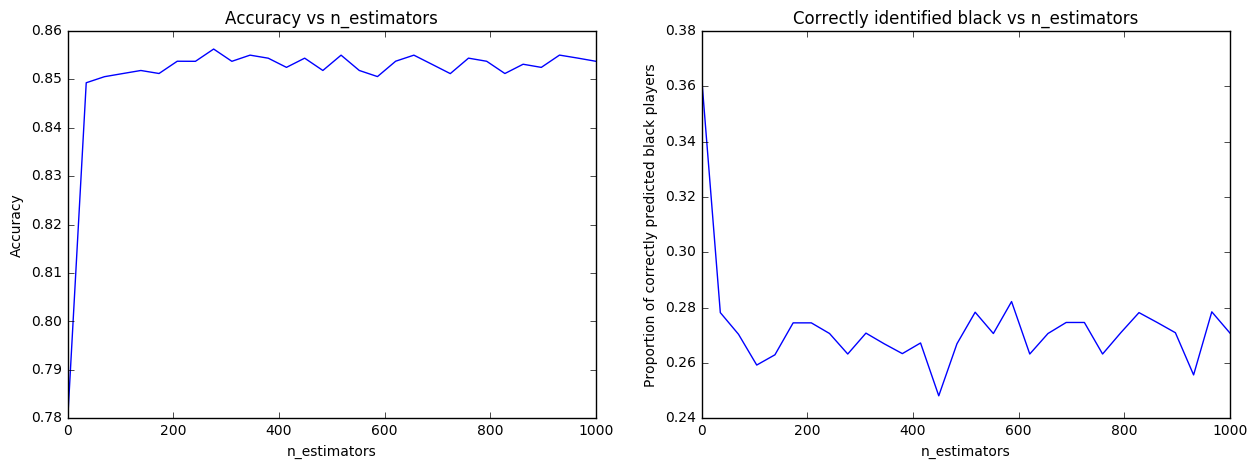

In [42]:
#plot_curve(acc_n_estimators, acc_n_estimators_bp, n_estimators_values, 'n_estimators')

We see that the values begin to stabilize quite fast, so we try to look at the graph at a higher granularity for lower values of N-estimators. The following cell plots the scores for all values of n_estimators from 1 to 100.

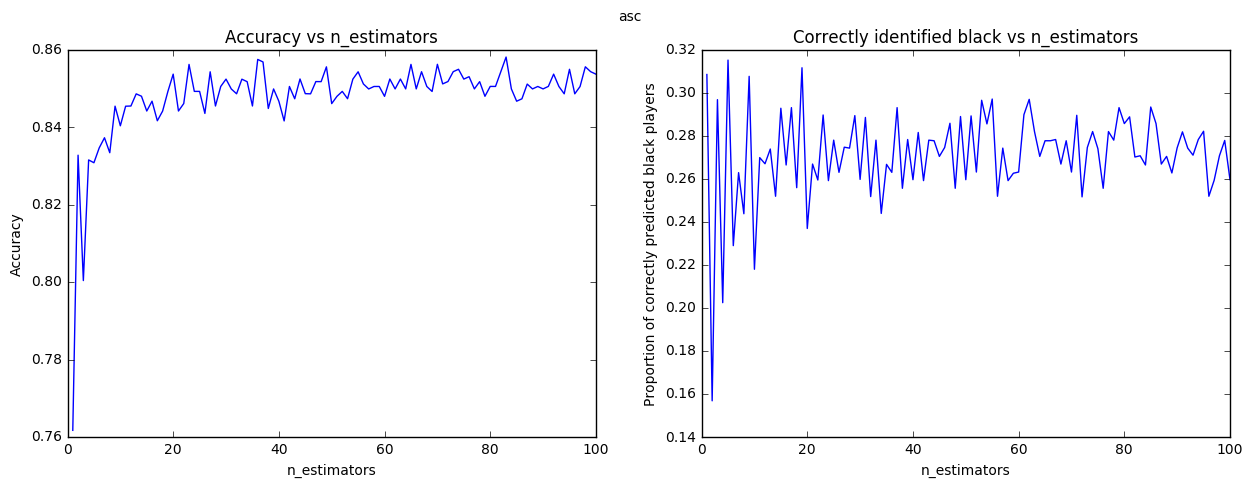

In [108]:
fig = plot_curve(acc_n_estimators, acc_n_estimators_bp, n_estimators_values, 'n_estimators')
fig.suptitle('asc')

We see that the accuracy stabilizes to within 1% at around 20 n_estimators. But the 'Proportion of correctly predicted black players' does not really seem to stabilize. Also, observe that while 'Proportion of correctly predicted black players' is always oscillating, the peaks are always when n_estimators is odd. We do not have any explanation for this, but it seems to hold for n_estimators until 40. 

So instead of deciding on a value, we decide to use n_estimators between [18, 22], because accuracy starts to stabilize at this point and the oscillations of 'Proportion of correctly predicted black players' become less wild around this point.

### Max_depth

* We try different max_depths for the range of n_estimators which we decided on to get the best combination.
* We plot the accuracy and black accuracy of our model for different max_depths for all the values of n_estimators in the interval we decided on above and choose the best one based on the graphs.

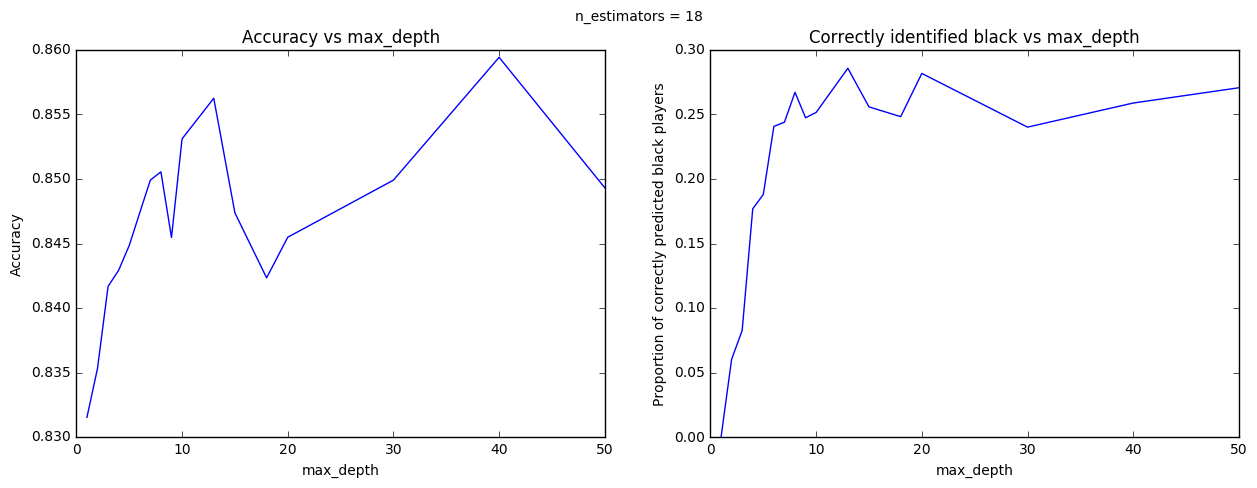

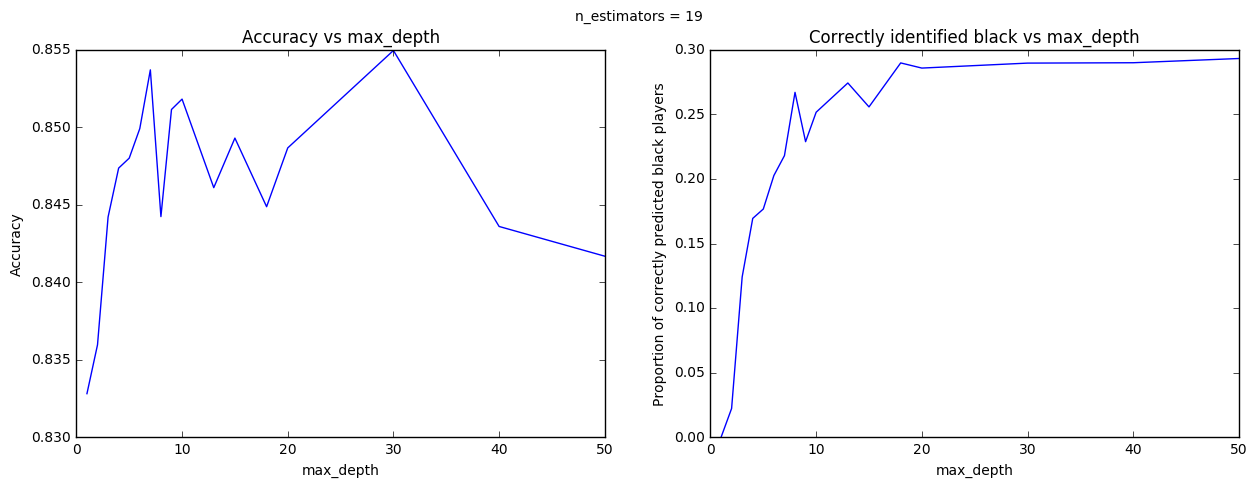

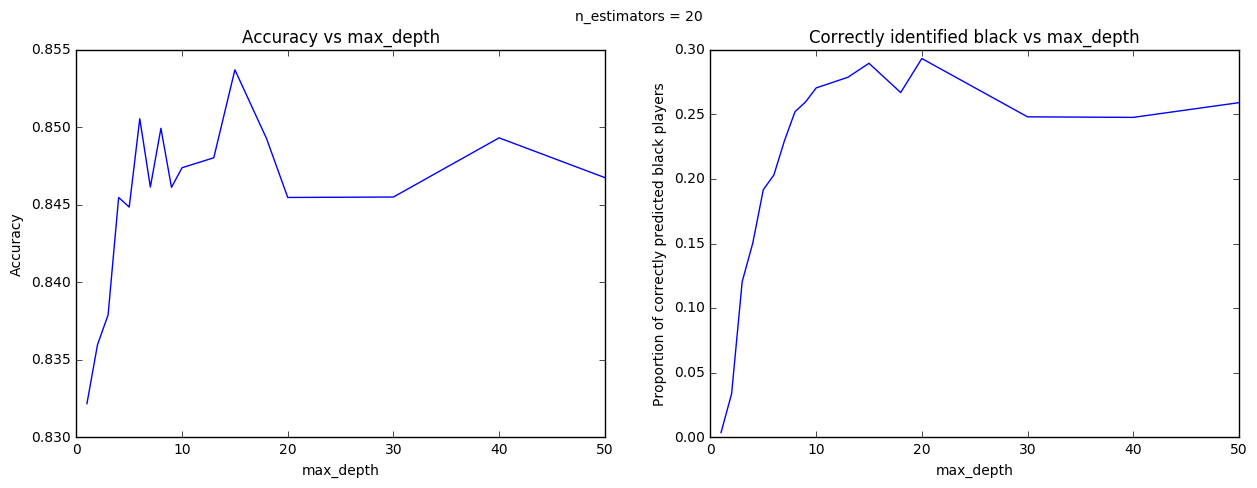

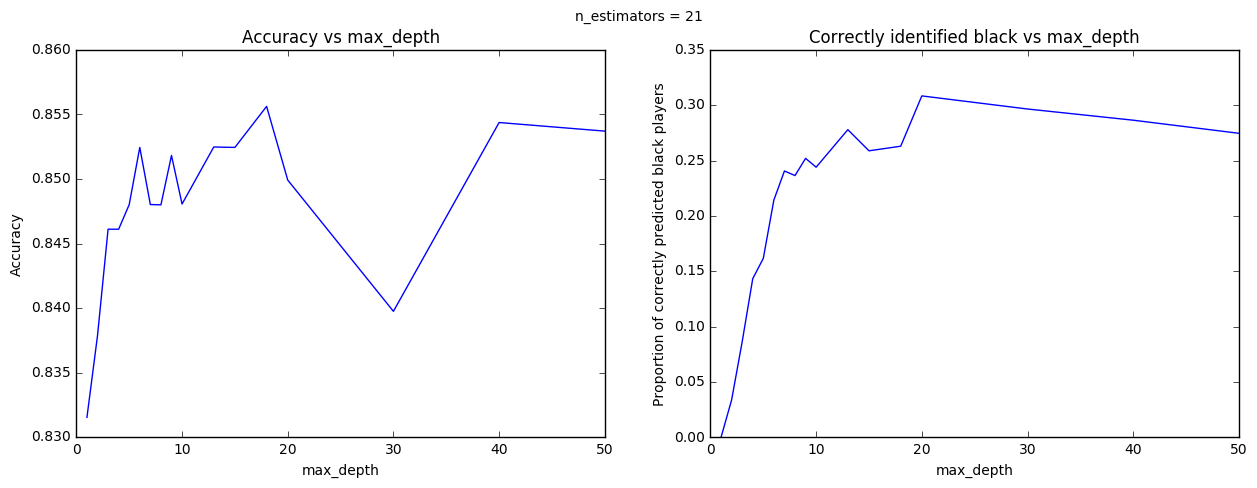

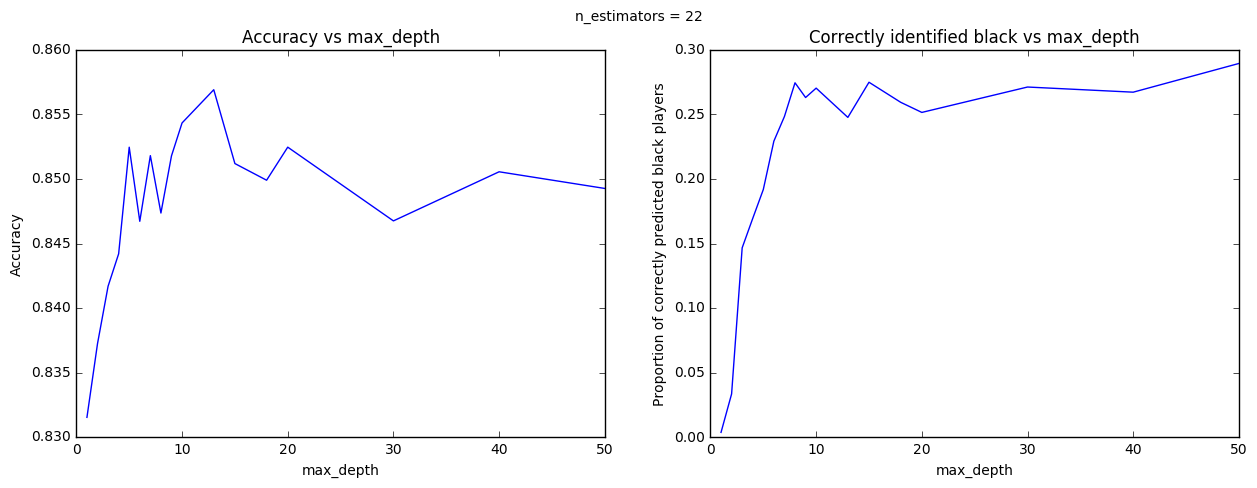

In [112]:
#Max_depth parameter for the random forest classifier

#Let's create a list with possible values for the max_depth
max_depth_val = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 18, 20, 30, 40, 50 ]

for n in range(18, 23):
    acc_max_depth = []
    acc_max_depth_bp = []
    for i in max_depth_val:
        rfc=RandomForestClassifier(n_estimators = n,max_depth=i)
        #Again, we will use the cross validation with k_fold=10 to obtain the accuracy of the random forest.
        cross_val_score = np.mean(sklearn.model_selection.cross_val_score(rfc, x, y, cv=10,scoring='accuracy'))
        cross_val_score_bp = np.mean(sklearn.model_selection.cross_val_score(rfc, x, y, cv=10,scoring=black_predicted))
        acc_max_depth.append(cross_val_score)
        acc_max_depth_bp.append(cross_val_score_bp)
    fig = plot_curve( acc_max_depth, acc_max_depth_bp, max_depth_val, 'max_depth')
    fig.suptitle("n_estimators = {}".format(n))
    time.sleep(1)

We do not want the max depth to be too high to avoid overfitting. Among the different values of n_estimator that we ran it for, n_estimator = 19 is the only one where we see that the accuracy is becoming stable after not a very large value of max_depth. It stabilizes around max_depth = 20. So we choose n_estmators = 19 and max_depth = 20.

### Max_features

We plot similar graphs for max_features but we do not really get much information

In [348]:
#Max_features parameter for the random forest classifier

#We will vary the number of features from 1 to the maximum number of features we have in our dataframe
max_features_val=range(1,x.shape[1],1)
acc_max_features = []
acc_max_features_bp = []
for i in max_features_val:
    #we start seeing an stabilization for the accuracy.
    rfc=RandomForestClassifier(n_estimators = 19, max_depth = 20, max_features=int(i))
    #Once again we will use the cross validation with k_fold value=10 to see the accuracy.
    cross_val_score = np.mean(sklearn.model_selection.cross_val_score(rfc, x, y, cv=10,scoring='accuracy'))
    cross_val_score_bp = np.mean(sklearn.model_selection.cross_val_score(rfc, x, y, cv=10,scoring=black_predicted))
    acc_max_features.append(cross_val_score)
    acc_max_features_bp.append(cross_val_score_bp)

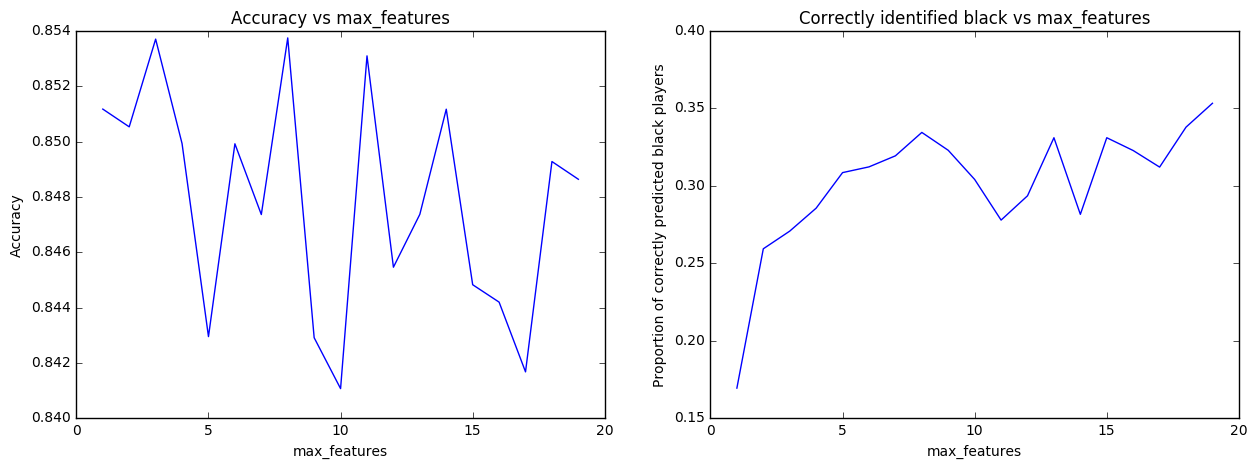

In [349]:
fig = plot_curve( acc_max_features, acc_max_features_bp, max_features_val, 'max_features')

In [426]:
print('Accuracy [mean]: %f' % (np.mean(acc_max_features)*100))
print('Accuracy for max_features = 7: %f' % (acc_max_features[6]*100))

Accuracy [mean]: 84.784365
Accuracy for max_features = 7: 84.736397


We will take a value of max_features = 7, as we can see in the graph that is the one in where the stabilization begins (and the closer to the mean of all the values we got for the stabilization, and after that the accuracy is changing a little bit.

## Training the Random Forest Classifier

In [287]:
#Training Random Forest with the parameters that were found
rfc=RandomForestClassifier(n_estimators=19, max_depth=20, max_features=7)

In [371]:
#Taking a look at the cross validation to see if the model is overfitting or not (we are considering a k_fold = 10)
accuracy = sklearn.model_selection.cross_val_score(rfc, x, y, cv = 10, scoring='accuracy')
print( accuracy, "\nAverage accuracy = ", sum(accuracy)*100/len(accuracy))

[ 0.8490566   0.81761006  0.88679245  0.83544304  0.88607595  0.83544304
  0.85350318  0.86624204  0.84076433  0.84076433] 
Average accuracy =  85.1169503016


### Confusion Matrix

We are going to get the confusion matrix to see how our model behaves, for that we  split the sample into 
train data and test data at a 0.4 ratio, we will fit the train data into the random forest already created (rfc),
make some predictions and get the confusion matrix and the accuracy.

In [337]:
# Train test split of data and training the model
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.40)
rfc = rfc.fit(X_train, y_train)
y_predict = rfc.predict(X_test)
cm = confusion_matrix(y_test, y_predict)
accuracy = sum(y_test == y_predict)/(len(y_test))*100
print('Accuracy: %f%%' % accuracy)

Accuracy: 85.917722%


The `plot_confusion_matrix` function was adapted from: 
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

In [139]:
def plot_confusion_matrix(cm, y_values):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    tick_marks = np.arange(len(y_values))
    plt.xticks(tick_marks,y_values)
    plt.yticks(tick_marks,y_values)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

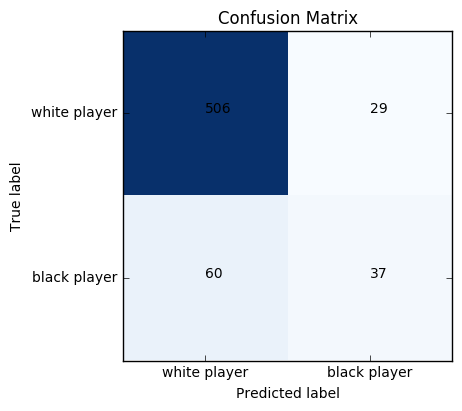

In [340]:
#we create a list with the two possible values of the labels (0 is for white people and 1 is for black people)
y_values=['white player','black player'] 
plot_confusion_matrix(cm,y_values)

As we can see in the confusion Matrix, the model predicted most values as white (but we already saw that there are 1313 white players vs 266 black players). Note that the accuracy would be 83% even if you just predict all players to be white due to the large number of white players. In fact we can see that most of the black players have been predicted incorrectly, and the high accuracy is simply because of large number of white players. 

**Note:** We had not considered the scoring criteria 'Black accuracy' earlier. But when we saw the confusion matrix, we decided that we also need to look at an alternate scoring criteria and therefore added that. Earlier we were getting only around 25% of black players correct, which improved to around 35-40% after tuning the parameters to consider also the 'Black accuracy' criteria. But we believe that the prediction accuracy is still not significant enough to concludethat there is racism on part of the referees.

### Feature importance

In [355]:
#Feature importances
rfc =rfc.fit(x, y)
importances = rfc.feature_importances_
indices=sorted(range(len(importances)), key=lambda k: importances[k],reverse=True)

print("Feature ranking:")
for n_index in range(len(indices)):
    print("%d.- %s: %f" % (n_index + 1, columns_x[indices[n_index]], importances[indices[n_index]]))

Feature ranking:
1.- seIAT: 0.136846
2.- meanExp: 0.099111
3.- meanIAT: 0.073291
4.- nExp: 0.064613
5.- seExp: 0.058884
6.- goals: 0.053084
7.- weight: 0.047773
8.- club: 0.046062
9.- leagueCountry: 0.045192
10.- nIAT: 0.044971
11.- games: 0.044904
12.- position: 0.043189
13.- defeats: 0.041609
14.- yellowCards: 0.038938
15.- victories: 0.038700
16.- height: 0.038503
17.- ties: 0.031739
18.- redCards: 0.021183
19.- refCountry: 0.016067
20.- yellowReds: 0.015341


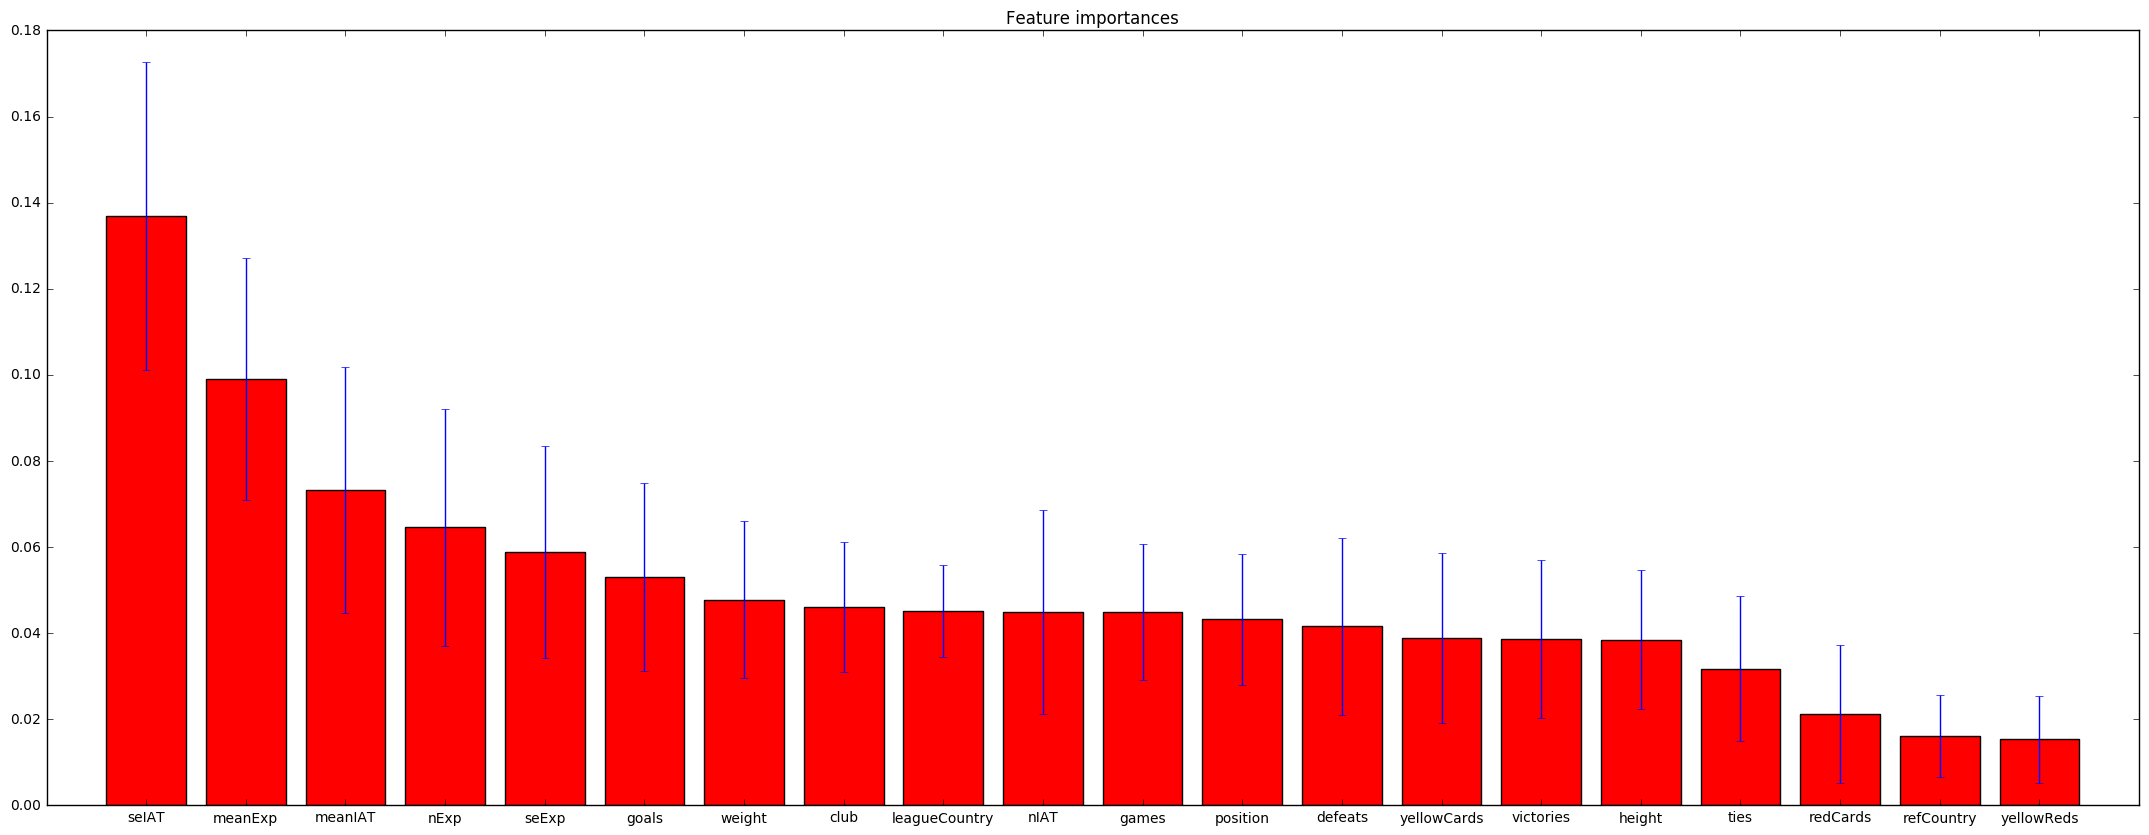

In [356]:
#Getting the standard deviaton of the feature importances:
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],axis=0)

#Plotting the important features
plt.figure(figsize=(27, 10))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices],yerr=std[indices],align="center",color='r')
plt.xticks(range(len(indices)),(columns_x[i] for i in indices))
plt.xlim([-1, len(indices)])
plt.show()

We can see that the most important features are those who contain "biased" values:

* 1.- seIAT
* 2.- seExp
* 3.- meanExp
* 4.- meanIAT
* 5.- nIAT
* 6.- nExp

Let's drop them and see what we get.

In [357]:
#Dropping the mentioned features
x_no_bias=x.drop(['seIAT','seExp','meanExp','meanIAT','nExp','nIAT'], 1)
x_no_bias_columns=x_no_bias.columns

In [395]:
#Let's create a new  random forest classifier with the parameters founded previously
rfc_no_bias = RandomForestClassifier(n_estimators = 19, max_depth = 20, max_features = 7)
#We perform the cross validation just to see the accuracy and if the model is overfitting or not.
accuracy = sklearn.model_selection.cross_val_score(rfc_no_bias, x_no_bias, y, cv=20, scoring='accuracy')
print( accuracy, "\nAverage accuracy = ", sum(accuracy)*100/len(accuracy))

[ 0.8375      0.8         0.8375      0.8625      0.8375      0.825
  0.82278481  0.84810127  0.87341772  0.86075949  0.78481013  0.84810127
  0.82278481  0.83333333  0.84615385  0.8974359   0.82051282  0.85897436
  0.84615385  0.85897436] 
Average accuracy =  84.111489776


In [396]:
rfc_no_bias =rfc_no_bias.fit(x_no_bias, y)
importances = rfc_no_bias.feature_importances_
indices=sorted(range(len(importances)), key=lambda k: importances[k],reverse=True)

print("Feature ranking:")
for n_index in range(len(indices)):
    print("%d.- %s: %f" % (n_index + 1, x_no_bias_columns[indices[n_index]], importances[indices[n_index]]))

Feature ranking:
1.- victories: 0.094482
2.- club: 0.093097
3.- goals: 0.090268
4.- yellowCards: 0.089718
5.- defeats: 0.082658
6.- weight: 0.081009
7.- games: 0.079519
8.- ties: 0.075331
9.- height: 0.072202
10.- refCountry: 0.062826
11.- position: 0.062096
12.- leagueCountry: 0.059698
13.- yellowReds: 0.028792
14.- redCards: 0.028304


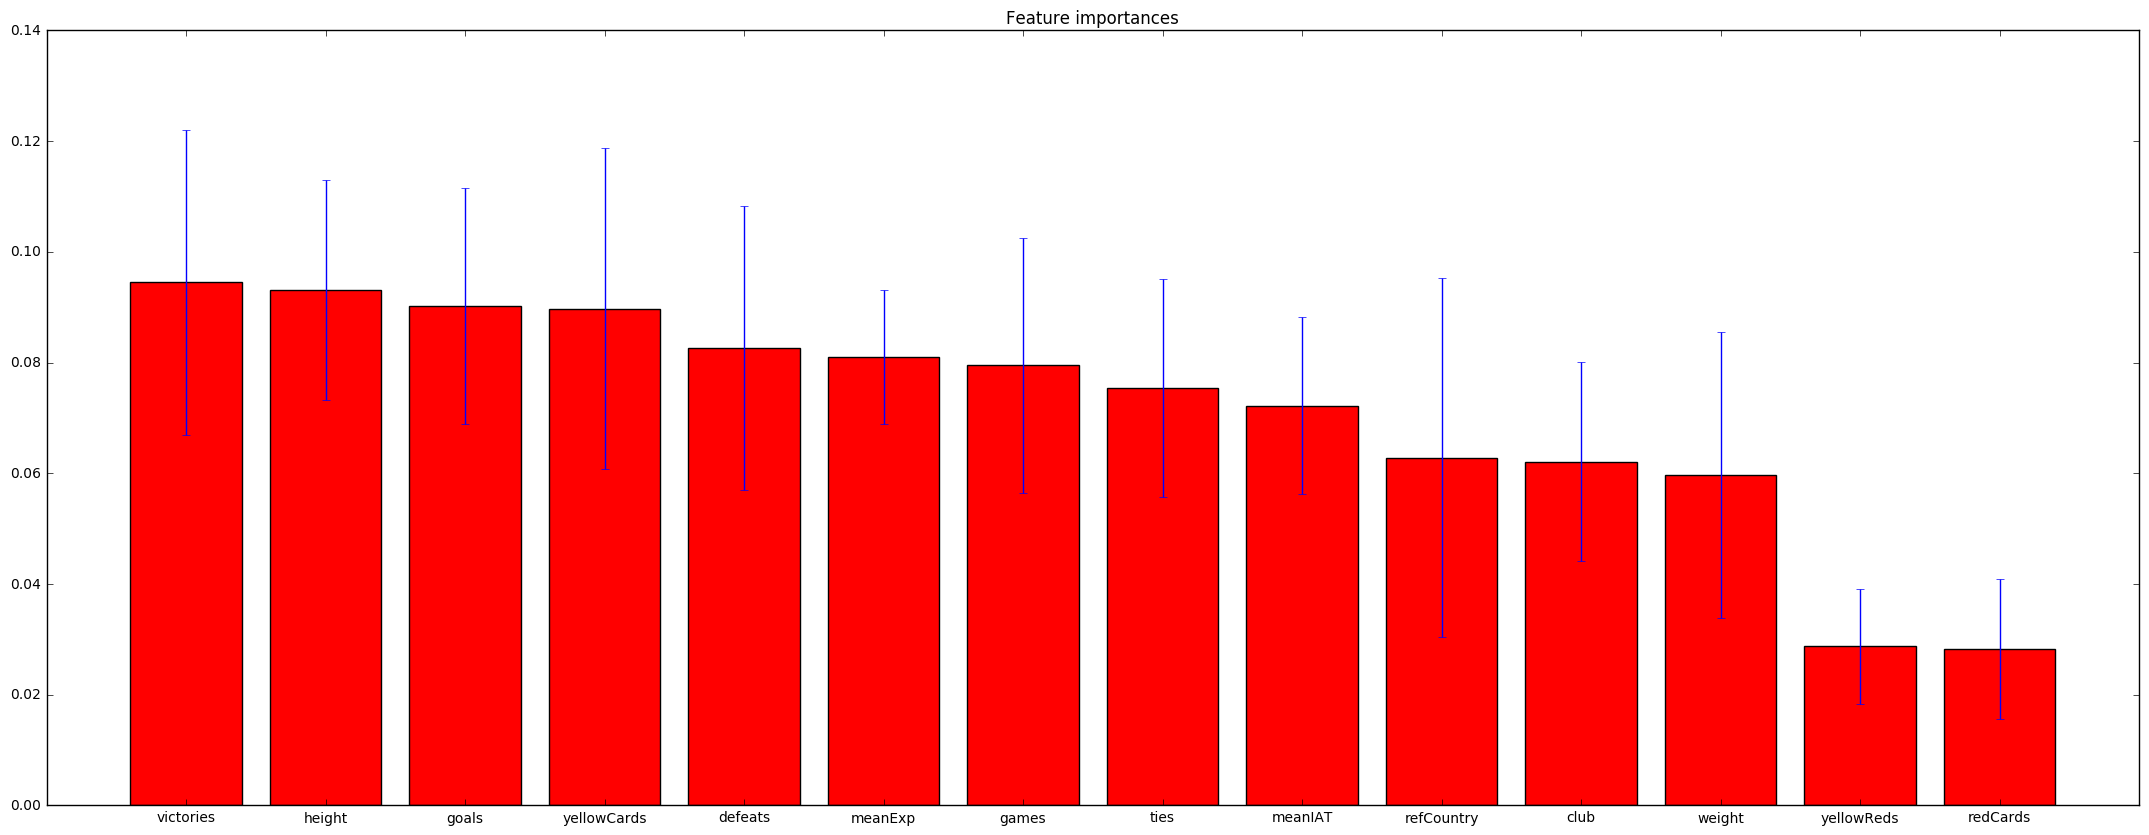

In [397]:
#Getting the standard deviaton of the feature importances:
std_no_bias = np.std([tree.feature_importances_ for tree in rfc_no_bias.estimators_],axis=0)

#Plotting the important features
plt.figure(figsize=(27, 10))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices],yerr=std_no_bias[indices],align="center",color='r')
plt.xticks(range(len(indices)),(columns_x[i] for i in indices))
plt.xlim([-1, len(indices)])
plt.show()

It seems that the order of the important features did not change so much, we still see almost the same behavior for the rest of the features.

## Bonus: Plotting Learning Curves

We plot the learning curves with different parameter sets, and notice which ones have high bias and which ones do not. We then explain why there is a high bias, and how being unbalanced increases the bias.

In [398]:
from helpers import plot_learning_curve # adapted from scikit-learn documentation

### Low Bias

<module 'matplotlib.pyplot' from '/home/kirtan/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

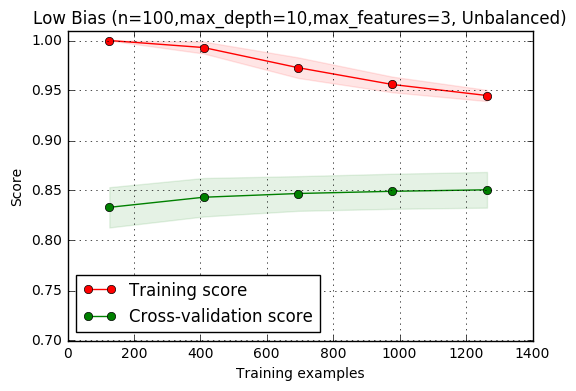

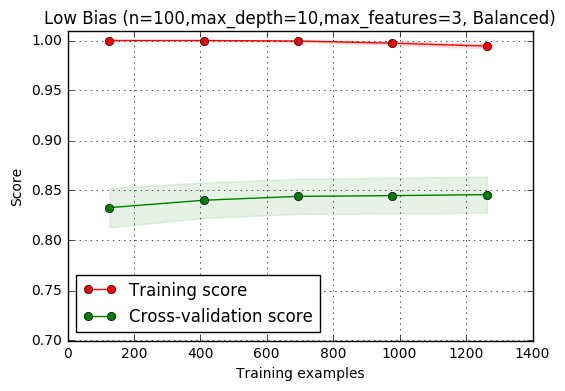

In [400]:
# Cross validation with 100 iterations to obtain smoother curves
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state = 0)

# Plot 1
# ------------------------------------
title = "Low Bias, Unbalanced)" estimator = RandomForestClassifier(n_estimators = 100, max_depth = 10,max_features = 3) 
plot_learning_curve(estimator, title, x, y, ylim=(0.7, 1.01), cv=cv, n_jobs = 4)

# Plot 2
# ------------------------------------
title = "Low Bias, Balanced)"
estimator = rfc=RandomForestClassifier(n_estimators = 100,max_depth = 10,max_features = 3,class_weight='balanced')
plot_learning_curve(estimator, title, x, y, ylim=(0.7, 1.01), cv=cv, n_jobs = 4)


### High Bias

There is a high bias when there is depth is low. A depth of 1 corresonds to a boolean function of one feature, so it does not represent the model well. This is especially evident when the class is balanaced. In that case, the model cannot simply output "black" for all users. (see below for explanation for balanced classes).

<module 'matplotlib.pyplot' from '/home/kirtan/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

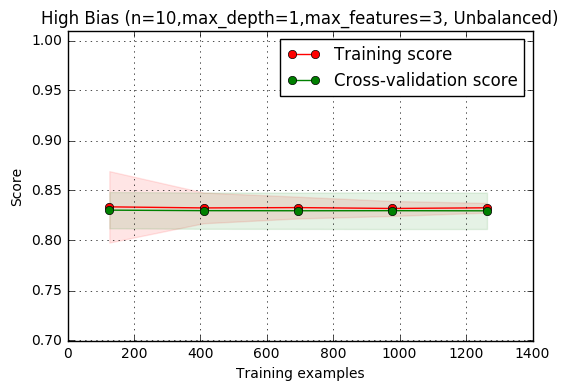

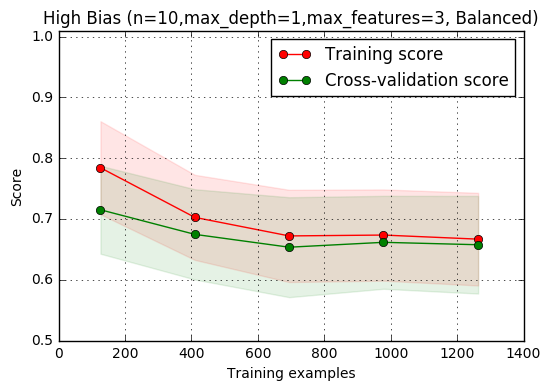

In [74]:
# Plot 3
# ------------------------------------
title = "High Bias (n=10,max_depth=1,max_features=3, Unbalanced)"
estimator = RandomForestClassifier(n_estimators = 10, max_depth = 1, max_features = 3) 
plot_learning_curve(estimator, title, x, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

# Plot 4
# ------------------------------------
title = "High Bias (n=10,max_depth=1,max_features=3, Balanced)"
estimator = RandomForestClassifier(n_estimators = 10, max_depth = 1, max_features = 3, class_weight='balanced') 
plot_learning_curve(estimator, title, x, y, ylim=(0.5, 1.01), cv=cv, n_jobs=4)

The bias is still high even when there are many trees sampled. See below plots.

<module 'matplotlib.pyplot' from '/home/kirtan/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

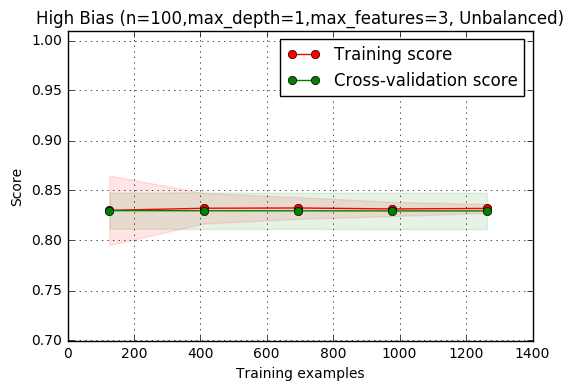

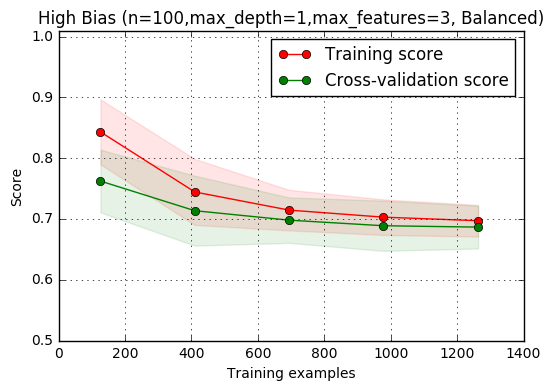

In [76]:
# Plot 5
# ------------------------------------
title = "High Bias (n=100,max_depth=1,max_features=3, Unbalanced)"
estimator = RandomForestClassifier(n_estimators = 100, max_depth = 1, max_features = 3) 
plot_learning_curve(estimator, title, x, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

# Plot 6
# ------------------------------------
title = "High Bias (n=100,max_depth=1,max_features=3, Balanced)"
estimator = RandomForestClassifier(n_estimators = 100, max_depth = 1, max_features = 3, class_weight = 'balanced') 
plot_learning_curve(estimator, title, x, y, ylim=(0.5, 1.01), cv=cv, n_jobs=4)

The high bias happens when the depth is low, such as 1. The number of estimators do not impact whether a classifier is highly biased or not. If we balance our trees, we notice that there is very high bias and low accuracy scores with there is low depth. This is a good warning because when it is unbalanced, the curve predicts all players to be black.

### Note on Balance Class

Balancing class size prevent the decision tree to bias towards one class. This is done using the `class_weight` parameter in `RandomForestClassifier`. "The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))` (source: Scikit-learn documentation)

Recall that there is a large difference in size between white and black players. That means that if the forest predicts white players every single time, it will achieve an accuracy of  `1313/(266+1313) = 83.15%`.

In [77]:
print('White players: %i' % sum(y==b'0'))
print('Black players: %i' % sum(y==b'1'))

White players: 1313
Black players: 266


## 2. Clustering
In this part, we have been asked to aggregate the referee information grouping by soccer player. So we should only keep the columns relevant to the refree. We decide to keep the columns ['seIAT', 'seExp', 'meanExp', 'meanIAT', 'nIAT', 'nExp', 'yellowCards', 'yellowReds', 'redCards', 'refCountry'].

We then try to use kmeans clustering to get well separated clusters which separate white and black players.

In [107]:
# The set of true labels
y = np.asarray(df_ml['race_val'], dtype = "int")

#Discretizing the values of y: 1 is for black players and 0 is for white players
for i in range(len(y)):
    if y[i] > 0.5:
        y[i] = 1
    else:
        y[i] = 0

In [114]:
# The data
ref_cols = ['seIAT', 'seExp', 'meanExp', 'meanIAT', 'nIAT', 'nExp',
            'yellowCards', 'yellowReds', 'redCards', 'refCountry' ]

x = df_ml[ref_cols]

# We standardize the data as kmeans is isotropic
x = StandardScaler().fit_transform(x)

x = pd.DataFrame(x, columns = ref_cols)

In [117]:
# Calculating how well the cluster separates the white and black players. We choose the label which maximizes 'correctness'
def cl_accuracy(labels, y):
    correctness = np.mean([int(np.abs(diff) == 0) for diff in labels - y])
    if correctness < 0.5:
        labels = 1 - labels
    return(np.mean([int(np.abs(diff) < 0.5) for diff in labels - y]))

In [130]:
from sklearn.cluster import KMeans

# We first try to run the clustering on 
kmeans = KMeans(n_clusters = 2,  n_init = 20, random_state = 10).fit(x)
predictions = kmeans.labels_

print("Silhouette score = {}".format(sklearn.metrics.silhouette_score(x, predictions)))
print("Quality of separation = {}".format(cl_accuracy(predictions, y)))

Silhouette score = 0.28818222288343565
Quality of separation = 0.7188093730208993


We then remove features iteratively as asked for in the question and plot the silhoutte score against the number of features to get an idea of what is going on.

In [131]:
# Quality of separation between white and black
accuracy = []

# Silhoutte score
silh_score = []

for i in range(x.shape[1]):
    x1 = x.iloc[:, 0:i+1]
    kmeans = KMeans(n_clusters = 2, n_init = 20, random_state = 15).fit(x1)
    silhoutte = sklearn.metrics.silhouette_score(x, kmeans.labels_)
    silh_score.append(silhoutte)
    accuracy.append(cl_accuracy(kmeans.labels_, y))
    

We plot how well the white and black players are separated as well as accuracy against the number of features.

Maximum accuracy : 0.8701709943


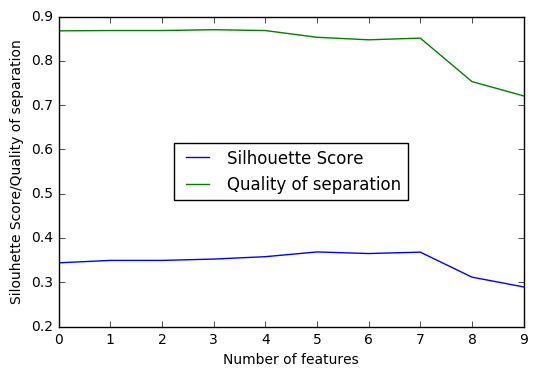

In [132]:
plt.plot(silh_score,label='Silhouette Score')
plt.plot(accuracy,label='Quality of separation')
plt.xlabel('Number of features')
plt.ylabel('Silouhette Score/Quality of separation')
plt.legend(loc=10, bbox_to_anchor=(0.5,0.5))
print('Maximum accuracy :', max(accuracy))

The results seem quite strange. We get that though the clusters are not well separated at all, the clustering separates the white and black players quite well, even with just one feature. The single feature in this case is seIAT. We do further analysis to figure out what is going on.

We take the two most relevant features which give us high 'Quality of separation' and look at the clusters visually in 2D.

Silhouette score = 0.8257969782220322
Quality of separation = 0.8682710576314123


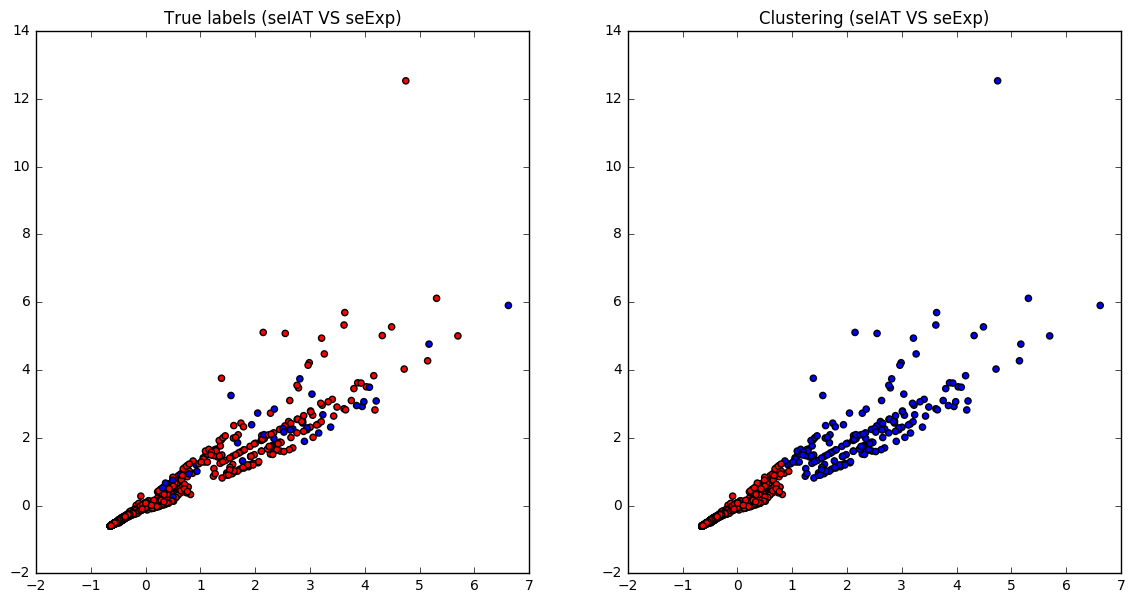

In [143]:
x1 = x.iloc[:, 0:2]
kmeans = KMeans(n_clusters = 2, n_init = 20, random_state = 16).fit(x1)
predictions = kmeans.labels_

print("Silhouette score = {}".format(sklearn.metrics.silhouette_score(x1, predictions)))
print("Quality of separation = {}".format(cl_accuracy(predictions, y)))

# Set the size of the plot
plt.figure(figsize=(14,7))
 
# Create a colormap
colormap = np.array(['red', 'blue'])
 
# Plot Sepal
plt.subplot(1, 2, 1)
plt.scatter(x1.seExp, x1.seIAT, c = colormap[y], s = 20)
plt.title('True labels (seIAT VS seExp)')
 
plt.subplot(1, 2, 2)
plt.scatter(x1.seExp, x1.seIAT, c = colormap[kmeans.labels_], s = 20)
plt.title('Clustering (seIAT VS seExp)')

We can see why the silhoutte score is low. Clearly, there is not a good separation of the dataset into two distinct clusters. We plot the confusion matrix to figure out what is going on with the accuracy.

In [137]:
cm = confusion_matrix(y, predictions)


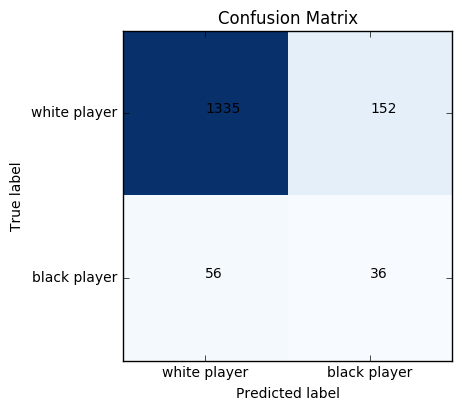

In [140]:
y_values=['white player','black player'] 
plot_confusion_matrix(cm,y_values)

We can see that we have the same problem again of having too many white players which causes the accuracy to be too high. 

We conclude that we cannot get a good separation which has both high accuracy and a good silhoutte score from just the refree columns and therefore we do not have a conclusive evidence on racism.